In [ ]:
#pip install cmake
#pip install face_recognition
#pip install efficientnet_pytorch

   ---------------------------------------- 0.0/36.7 MB ? eta -:--:--
   -------------- ------------------------- 13.1/36.7 MB 82.3 MB/s eta 0:00:01
   ------------------------- -------------- 23.6/36.7 MB 59.8 MB/s eta 0:00:01
   ---------------------------------------  36.4/36.7 MB 61.0 MB/s eta 0:00:01
   ---------------------------------------- 36.7/36.7 MB 47.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Face-to-BMI Prediction using EfficientNet

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from efficientnet_pytorch import EfficientNet
import inspect
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Using device: cpu


## Data-preprocessing

In [ ]:
data_path = 'data.csv'  
image_path = r"C:\Users\lizha\Desktop\学期3\ML2\Final\Images"  

df_raw = pd.read_csv(data_path)
print(f"Dataset loaded: {len(df_raw)} samples")
print(df_raw.head())

Dataset loaded: 4206 samples
   Unnamed: 0        bmi  gender  is_training       name
0           0  34.207396    Male            1  img_0.bmp
1           1  26.453720    Male            1  img_1.bmp
2           2  34.967561  Female            1  img_2.bmp
3           3  22.044766  Female            1  img_3.bmp
4           4  37.758789  Female            1  img_4.bmp


In [ ]:
from pathlib import Path
import pandas as pd

IMAGE_DIR = Path(r"C:\Users\lizha\Desktop\学期3\ML2\Final\Images").resolve()

missing = []
for fname in df_raw["name"]:
    p = IMAGE_DIR / fname
    if not p.exists():
        missing.append(p)

print(f"\nMissing files: {len(missing)}")
df = df_raw[df_raw["name"].apply(lambda f: (IMAGE_DIR / f).exists())].reset_index(drop=True)
print("Kept", len(df), "rows; dropped", len(df_raw) - len(df))


Missing files: 244
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_4.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_5.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_40.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_86.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_93.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_112.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_113.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_238.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_239.bmp
 • C:\Users\lizha\Desktop\学期3\ML2\Final\Images\img_300.bmp
.bmp exists -> False
.jpg exists -> False
.png exists -> False



Dataset Statistics:
Number of training samples: 3210
Number of testing samples: 752
Gender distribution: {'Male': 2354, 'Female': 1608}
BMI range: 17.7162162162 - 85.9870605469


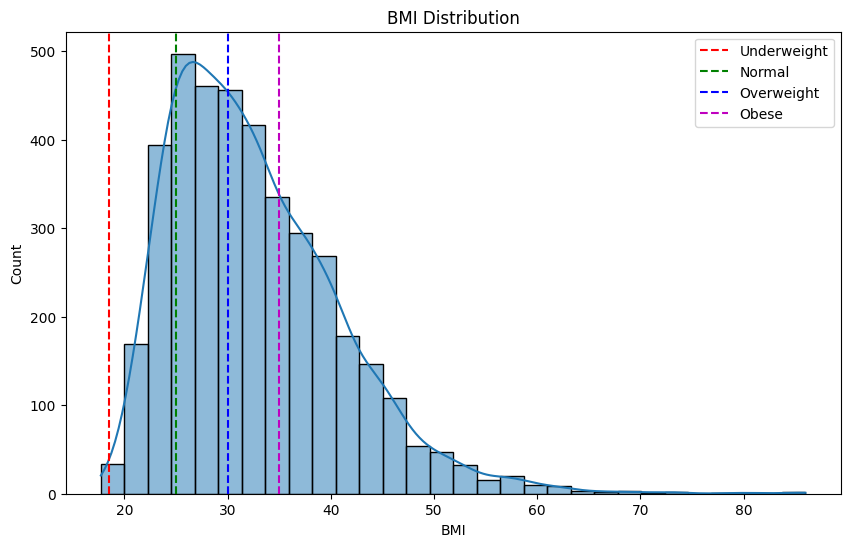


BMI Category Distribution:
bmi_category
Overweight             1087
Moderate Obesity        885
Very Severe Obesity     695
Normal                  663
Severe Obesity          625
Underweight               7
Name: count, dtype: int64

Final splits: Train 2728, Validation 482, Test 752


In [9]:
# Basic dataset statistics
print("\nDataset Statistics:")
print(f"Number of training samples: {len(df[df['is_training'] == 1])}")
print(f"Number of testing samples: {len(df[df['is_training'] == 0])}")
print(f"Gender distribution: {df['gender'].value_counts().to_dict()}")
print(f"BMI range: {df['bmi'].min()} - {df['bmi'].max()}")

# Visualize BMI distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.axvline(18.5, color='r', linestyle='--', label='Underweight')
plt.axvline(25, color='g', linestyle='--', label='Normal')
plt.axvline(30, color='b', linestyle='--', label='Overweight')
plt.axvline(35, color='m', linestyle='--', label='Obese')
plt.legend()
plt.show()

# Create BMI category based on standard ranges
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    elif bmi < 35:
        return 'Moderate Obesity'
    elif bmi < 40:
        return 'Severe Obesity'
    else:
        return 'Very Severe Obesity'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)
print("\nBMI Category Distribution:")
print(df['bmi_category'].value_counts())

# Split the training data for validation
train_df = df[df['is_training'] == 1].copy()
test_df = df[df['is_training'] == 0].copy()

# Further split training data to include a validation set
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['gender'])

print(f"\nFinal splits: Train {len(train_df)}, Validation {len(val_df)}, Test {len(test_df)}")


In [38]:
# Define data augmentation and preprocessing
class BMIDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx]['name'])
        
        # Load image using PIL for better compatibility with transforms
        try:
            image = Image.open(img_name).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_name} - {e}")
            # Return a placeholder black image if the file cannot be loaded
            image = Image.new('RGB', (224, 224), color='black')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Get BMI value
        bmi = self.dataframe.iloc[idx]['bmi']
        
        # Convert to tensor
        bmi = torch.tensor(bmi, dtype=torch.float32)
        
        if self.is_test:
            return image, bmi, self.dataframe.iloc[idx]['name']
        return image, bmi

# Define transformations with enhanced augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BMIDataset(train_df, image_path, transform=train_transforms)
val_dataset = BMIDataset(val_df, image_path, transform=val_transforms)
test_dataset = BMIDataset(test_df, image_path, transform=val_transforms, is_test=True)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


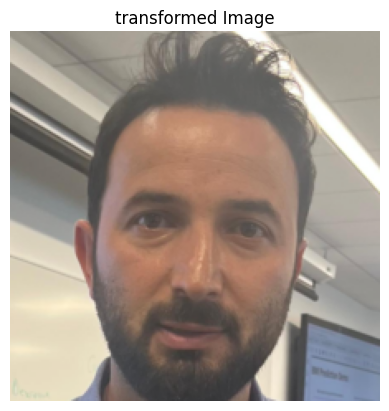

In [56]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_tensor(t):
    inv = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485,0.456,0.406],
                                   [0.229,0.224,0.225])],
        std=[1/s for s in [0.229,0.224,0.225]]
    )
    img = inv(t.cpu()).clamp(0,1)
    plt.imshow(img.permute(1,2,0))           
    plt.axis("off")

show_tensor(x[0])          
plt.title("transformed Image");


# EfficientNet - b0

In [ ]:
import torch, inspect, warnings
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Model Architecture
class EfficientBMI(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained("efficientnet-b0") \
                         if pretrained else EfficientNet.from_name("efficientnet-b0")
        n_in = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(n_in, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,128),   nn.BatchNorm1d(128), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x):                    
        return self.head(self.backbone(x)).squeeze(1)

model = EfficientBMI().to(device)

def plateau(opt, **kw):
    sig = inspect.signature(optim.lr_scheduler.ReduceLROnPlateau)
    kw  = {k:v for k,v in kw.items() if k in sig.parameters}
    return optim.lr_scheduler.ReduceLROnPlateau(opt, **kw)

criterion = nn.MSELoss()

# train head only with 2 epochs, AMP
for p in model.backbone.parameters(): p.requires_grad = False
opt_head = optim.Adam(model.head.parameters(), lr=3e-4, weight_decay=1e-4)
sch_head = plateau(opt_head, mode="min", factor=0.5, patience=2)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

for epoch in range(2):
    model.train(); running=0
    for x,y in tqdm(train_loader, leave=False):
        x,y = x.to(device), y.to(device)
        opt_head.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            loss = criterion(model(x), y)
        scaler.scale(loss).backward()
        scaler.step(opt_head); scaler.update()
        running += loss.item()*len(x)
    val_loss = 0
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):
        for x,y in val_loader:
            val_loss += criterion(model(x.to(device),), y.to(device)).item()*len(x)
    val_loss /= len(val_loader.dataset)
    sch_head.step(val_loss)
    print(f"  e{epoch+1}: train {(running/len(train_loader.dataset)):.3f}  val {val_loss:.3f}")



# unfreeze top blocks, per-group LR
for n,p in model.backbone.named_parameters():
    if "blocks.4" in n or "blocks.5" in n or "_conv_head" in n:   
        p.requires_grad = True

head_p = [p for n,p in model.named_parameters() if "head" in n]
base_p = [p for n,p in model.named_parameters() if p.requires_grad and "head" not in n]

optimizer = optim.Adam([
        {"params": head_p, "lr": 3e-4},
        {"params": base_p, "lr": 1e-5}
    ], weight_decay=1e-4)
scheduler = plateau(optimizer, mode="min", factor=0.3, patience=3)

best, counter, patience = 1e9, 0, 7

for epoch in range(1, 25):                                  
    # train
    model.train(); running = 0
    for x,y in tqdm(train_loader, leave=False):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            loss = criterion(model(x), y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        running += loss.item()*len(x)
    train_loss = running / len(train_loader.dataset)

    # validate 
    model.eval(); vl = 0; preds=[]; targs=[]
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            vl += criterion(out, y).item()*len(x)
            preds.append(out.cpu()); targs.append(y.cpu())
    vl /= len(val_loader.dataset)
    scheduler.step(vl)

    preds = torch.cat(preds).numpy(); targs = torch.cat(targs).numpy()
    mae = mean_absolute_error(targs, preds)

    print(f"  e{epoch:02d}: train {train_loss:.3f}  val {vl:.3f}  MAE {mae:.3f}")

    if vl < best:
        torch.save(model.state_dict(), "best_bmi_model.pt")
        best, counter = vl, 0
    else:
        counter += 1
        if counter >= patience: break

print(f"\n best val MSE {best:.5f}")


Loaded pretrained weights for efficientnet-b0


  e1: train 1016.387  val 1024.507


  e2: train 824.620  val 863.493


  e01: train 623.702  val 655.659  MAE 24.406


  e02: train 436.167  val 423.822  MAE 19.083


  e03: train 270.884  val 264.226  MAE 14.359


  e04: train 153.655  val 151.731  MAE 9.930


  e05: train 90.916  val 82.488  MAE 6.741


  e06: train 65.217  val 70.722  MAE 6.130


  e07: train 55.791  val 60.629  MAE 5.690


  e08: train 53.153  val 60.786  MAE 5.725


  e09: train 51.369  val 57.095  MAE 5.603


  e10: train 49.707  val 56.377  MAE 5.501


  e11: train 50.930  val 58.402  MAE 5.703


  e12: train 48.784  val 59.607  MAE 5.715


  e13: train 49.827  val 59.389  MAE 5.782


  e14: train 48.907  val 60.181  MAE 5.811


  e15: train 46.389  val 57.764  MAE 5.674


  e16: train 44.081  val 55.976  MAE 5.608


  e17: train 44.027  val 56.556  MAE 5.618


  e18: train 41.449  val 55.878  MAE 5.589


  e19: train 43.766  val 57.641  MAE 5.635


  e20: train 44.689  val 57.658  MAE 5.681


  e21: train 42.419  val 58.464  MAE 5.733


  e22: train 41.970  val 59.249  MAE 5.698


  e23: train 40.573  val 60.338  MAE 5.724


  e24: train 40.348  val 58.606  MAE 5.661

 best val MSE 55.87838


In [ ]:
import pandas as pd, csv, math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path

In [ ]:
# Evaluation on the test set
best_model = EfficientBMI().to(device)
best_model.load_state_dict(torch.load("best_bmi_model.pt", map_location=device))
best_model.eval()

preds, trues, names = [], [], []

with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=="cuda")):
    for x, y, fn in tqdm(test_loader, desc="predict"):
        out = best_model(x.to(device)).cpu()
        preds.extend(out.numpy())
        trues.extend(y.numpy())
        names.extend(fn)                

preds, trues = np.array(preds), np.array(trues)


# metrics
mae  = mean_absolute_error(trues, preds)
rmse = math.sqrt(mean_squared_error(trues, preds))
corr = np.corrcoef(trues, preds)[0,1] if len(np.unique(trues)) > 1 else 0

print(f"Test set:")
print(f"MAE   : {mae:7.3f}")
print(f"RMSE  : {rmse:7.3f}")
print(f"Corr  : {corr:7.3f}")

# save predictions
out_df = pd.DataFrame({
        "filename"      : names,
        "true_bmi"      : trues,
        "predicted_bmi" : preds,
        "abs_error"     : np.abs(trues - preds)
})
out_df.to_csv("bmi_predictions.csv", index=False)

Loaded pretrained weights for efficientnet-b0


predict: 100%|██████████| 47/47 [00:25<00:00,  1.85it/s]

Test set:
MAE   :   5.795
RMSE  :   8.194
Corr  :   0.494


In [ ]:
# Evaluation Split by gender
pred_df = pd.read_csv("bmi_predictions.csv")                    
meta_df = pd.read_csv("data.csv")                                

merged = pred_df.merge(meta_df, left_on="filename", right_on="name")

def get_metrics(df, label):
    mae = mean_absolute_error(df["true_bmi"], df["predicted_bmi"])
    rmse = math.sqrt(mean_squared_error(df["true_bmi"], df["predicted_bmi"]))
    corr = np.corrcoef(df["true_bmi"], df["predicted_bmi"])[0,1] if df["true_bmi"].nunique() > 1 else 0
    print(f"\n {label} metrics:")
    print(f"MAE   : {mae:7.3f}")
    print(f"RMSE  : {rmse:7.3f}")
    print(f"Corr  : {corr:7.3f}")

get_metrics(merged[merged["gender"] == "Male"], "Male")
get_metrics(merged[merged["gender"] == "Female"], "Female")



 Male metrics:
MAE   :   5.476
RMSE  :   7.676
Corr  :   0.561

 Female metrics:
MAE   :   6.214
RMSE  :   8.829
Corr  :   0.399


# PatchBMINet

In [ ]:
import warnings, inspect, math, numpy as np, pandas as pd, torch
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch import nn, optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

class PatchBMINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                 
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                
            nn.AdaptiveAvgPool2d((8,8)),     
            nn.Dropout(0.5)
        )


        self.attn = nn.Sequential(nn.Conv2d(64,64,1), nn.Sigmoid())

        self.fc = nn.Sequential(
            nn.Flatten(),                    
            nn.Linear(64*8*8, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x * self.attn(x)
        return self.fc(x).squeeze(1)

model = PatchBMINet().to(device)
print("trainable params:", sum(p.numel() for p in model.parameters())/1e6,"M")


# 2.  optimiser / scheduler 
def plateau(opt, **kw):
    ok = set(inspect.signature(optim.lr_scheduler.ReduceLROnPlateau).parameters)
    return optim.lr_scheduler.ReduceLROnPlateau(opt, **{k:v for k,v in kw.items() if k in ok})

opt  = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
sch  = plateau(opt, mode="min", factor=0.3, patience=3)
crit = nn.MSELoss()

best, wait, patience = 1e9, 0, 7
for epoch in range(1,15):
    # train 
    model.train(); tot=0
    for x,y in tqdm(train_loader, leave=False):
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        with autocast(enabled=device=="cuda"):
            loss = crit(model(x), y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        tot += loss.item()*len(x)
    tr = tot/len(train_loader.dataset)

    # validation
    model.eval(); tot=0
    with torch.no_grad(), autocast(enabled=device=="cuda"):
        for x,y in val_loader:
            tot += crit(model(x.to(device)), y.to(device)).item()*len(x)
    vl = tot/len(val_loader.dataset); sch.step(vl)
    print(f"e{epoch:02d}: train {tr:.3f}  val {vl:.3f}")

    if vl < best:
        torch.save(model.state_dict(),"best_patchcnn.pt")
        best, wait = vl, 0
    else:
        wait += 1
        if wait >= patience: break
print("best val MSE", best)


trainable params: 0.548097 M


e01: train 174.517  val 93.881


e02: train 79.162  val 80.805


e03: train 68.219  val 73.859


e04: train 65.013  val 72.508


e05: train 65.986  val 69.869
best val MSE 69.86890790472387


In [ ]:
#  Evaluate the patch-CNN on the held-out test set
import pandas as pd, numpy as np, math, torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from torch.cuda.amp import autocast

# reload checkpoint that matches this architecture
model = PatchBMINet().to(device)
model.load_state_dict(torch.load("best_patchcnn.pt", map_location=device))
model.eval()

#  forward-pass → collect predictions
preds, trues, names = [], [], []

with torch.no_grad(), autocast(enabled=device=="cuda"):
    for x, y, fn in tqdm(test_loader, desc="predict"):
        out = model(x.to(device)).cpu()
        preds.extend(out.numpy())
        trues.extend(y.numpy())
        names.extend(fn)

preds  = np.array(preds)
trues  = np.array(trues)

#  aggregate metrics
mae  = mean_absolute_error(trues, preds)
rmse = math.sqrt(mean_squared_error(trues, preds))
corr = np.corrcoef(trues, preds)[0, 1] if len(np.unique(trues)) > 1 else 0

print(f"\n Test-set metrics")
print(f"MAE   : {mae:7.3f}")
print(f"RMSE  : {rmse:7.3f}")
print(f"Corr  : {corr:7.3f}")

# save per-image predictions
pd.DataFrame({
    "filename"      : names,
    "true_bmi"      : trues,
    "predicted_bmi" : preds,
    "abs_error"     : np.abs(trues - preds)
}).to_csv("bmi_test_predictions.csv", index=False)


predict: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


 Test-set metrics
MAE   :   6.966
RMSE  :   9.359
Corr  :   0.092


# Utku's photo

In [ ]:
# ------------------------------------------------------------
# predict_bmi ─ run a single JPEG through *any* loaded model
# ------------------------------------------------------------
from PIL import Image
from torchvision import transforms

def predict_bmi(model, img_path, tfm, device=device):
    """
    model   – an *already-instantiated* net on the correct device
    img_path– str/Path to the jpg
    tfm     – the same transforms you used for validation / test
    """
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x   = tfm(img).unsqueeze(0).to(device)

    with torch.no_grad(), autocast(enabled=device=="cuda"):
        bmi = model(x).item()  
    print(f"{Path(img_path).name} → predicted BMI {bmi:.2f}")
    return bmi

In [50]:
# 1. build the correct class and load its checkpoint
net_eff = EfficientBMI().to(device)
net_eff.load_state_dict(torch.load("best_bmi_model.pt", map_location=device))

# 2. call the helper
predict_bmi(net_eff,
            r"C:\Users\lizha\Desktop\学期3\ML2\Final\Utku3.jpg",
            val_tfms)   

Loaded pretrained weights for efficientnet-b0
Utku3.jpg → predicted BMI 30.21


30.209970474243164

In [43]:
# 1. build + load the tiny CNN
net_patch = PatchBMINet().to(device)          # whatever you named it
net_patch.load_state_dict(torch.load("best_patchcnn.pt", map_location=device))

# 2. predict
predict_bmi(net_patch,
            r"C:\Users\lizha\Desktop\学期3\ML2\Final\Utku3.jpg",
            val_tfms)

Utku3.jpg → predicted BMI 31.55


31.5485897064209